In [4]:
# HIDDEN
from datascience import *
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [5]:
# Let's borrow a terribly tiny piece of data from https://onlinecourses.science.psu.edu/stat501/node/380
births=Table.read_table("data/birthsmokers.csv")
births

Wgt,Gest,Smoke
2940,38,1
3130,38,0
2420,36,1
2450,34,0
2760,39,1
2440,35,1
3226,40,0
3301,42,1
2729,37,0
3410,40,0


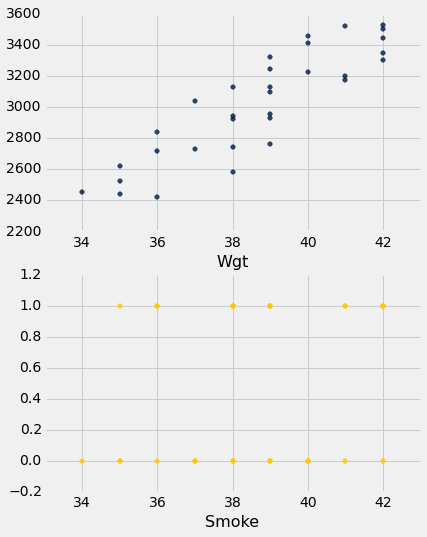

In [6]:
# First let's just look at what is here.  This needs to be a scatter, rather
# than a plot because there is no simple ordering - just relationships between
# birthweight and gestation time along with whether the mother smokes.
births.scatter('Gest')

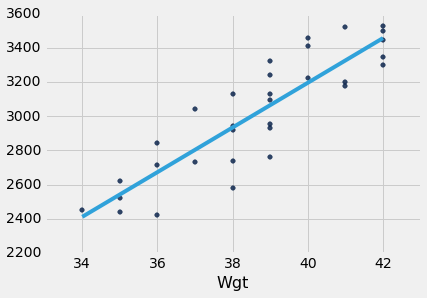

In [7]:
# As there is a trend among birthweight and gestation, we can fit a line to try to capture the trend
births.drop('Smoke').scatter('Gest', fit_line=True)

The question is whether smoking causes the trend to be substantially different.

In [8]:
# let's split this into two datasets
nosmoke=births.where('Smoke',0).drop('Smoke')
smoke=births.where('Smoke',1).drop('Smoke')

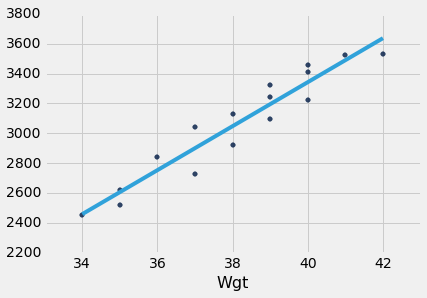

In [9]:
# we can attempt to find the trend for each
nosmoke.scatter('Gest',fit_line=True)

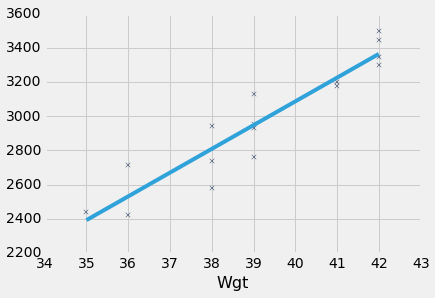

In [44]:
smoke.scatter('Gest',fit_line=True, marker='x')

In [11]:
# what is the equation of the line fitted to these data
np.polyfit(nosmoke['Gest'],nosmoke['Wgt'],1)

array([  147.20689655, -2546.13793103])

In [12]:
np.polyfit(smoke['Gest'],smoke['Wgt'],1)

array([  139.02874903, -2474.56410256])

We see that both the constant term and the weight increase per week is lower for the smokers.

At this point, we could do mx+b all over the place, or we could utilize higher order functions
to capture the concept of a model.  Here is an example, building such a model directly from the data.

In [13]:
# Build a linear model from data and return it is a function
def make_lm(x,y):
    m,b = np.polyfit(x,y,1)
    def lm(a):
        return m*a+b
    return lm 

In [14]:
# Create model of non-smokers that returns estimated weight a function of weeks gestation
nosmoker_weight = make_lm(nosmoke['Gest'], nosmoke['Wgt'])

In [15]:
nosmoker_weight(40)

3342.1379310344842

In [16]:
smoker_weight = make_lm(smoke['Gest'], smoke['Wgt'])

In [17]:
smoker_weight(40)

3086.5858585858573

In [18]:
# based on this data set, fitting the data to models of weight as a function of gestation
# We might conclude that at 40 weeks the effect of smoking on birthweigth in grams is
smoke_diff = nosmoker_weight(40)-smoker_weight(40)
smoke_diff

255.55207244862686

In [19]:
100*(nosmoker_weight(40)-smoker_weight(40))/nosmoker_weight(40)

7.6463652225605907

In [20]:
estimated_birthweight = Table([np.arange(32,44)],['week'])
estimated_birthweight['nosmoke'] = estimated_birthweight.apply(nosmoker_weight,'week')
estimated_birthweight['smoke'] = estimated_birthweight.apply(smoker_weight,'week')
estimated_birthweight

week,nosmoke,smoke
32,2164.48,1974.36
33,2311.69,2113.38
34,2458.9,2252.41
35,2606.1,2391.44
36,2753.31,2530.47
37,2900.52,2669.5
38,3047.72,2808.53
39,3194.93,2947.56
40,3342.14,3086.59
41,3489.34,3225.61


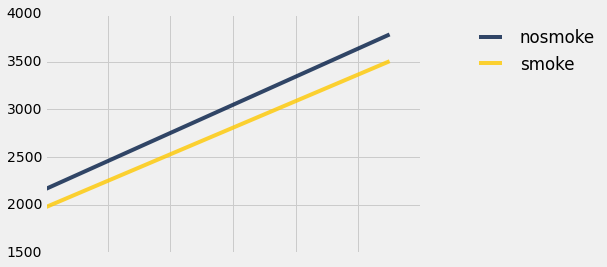

In [21]:
estimated_birthweight.plot('week',overlay=True)

At this point, we might ask how accurately these linear models fit the data.  The 'residual' in the fit would give us some idea of this.  But the error in summarizing a collection of empirical data with an analytical model is only a small part of the question.  The deeper point is that this data is not truth, it is merely a sample of a populations, and a tiny one at that.  We should be asking, is any inference drawn from this data valid for the population that the data is intended to represent.  Of course, the population is not directly observable,only the sample of it.  How can we use the sample we have to get some idea of how representative it is of the larger population.  That is what bootstrap seeks to accomplish.

In [22]:
# Construct a new model by constructing a new sample from our existing one and fiting a line to that
def rboot(table,x,y):
    sample = table.sample(table.num_rows,with_replacement=True)
    return np.polyfit(sample[x],sample[y],1)

In [23]:
# Try it out by hand, for non-smokers
rboot(nosmoke,'Gest','Wgt')

array([  140.75602176, -2327.64957265])

In [24]:
# And for smokers
rboot(smoke,'Gest','Wgt')

array([  119.77358491, -1741.08490566])

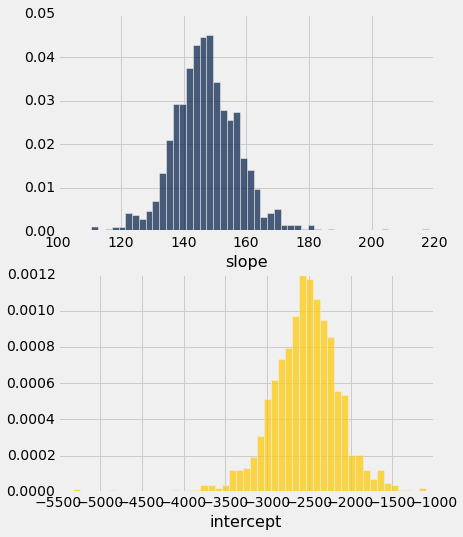

In [25]:
# Bootstrap a distribution of models by drawing many random samples, with replacement, from our samples
num_samples = 1000
nosamples = Table.from_rows([rboot(nosmoke,'Gest','Wgt') for i in range(num_samples)],['slope','intercept'])
nosamples.hist(bins=50,normed=True)

In [26]:
nosamples.stats([np.min,np.mean,np.max])

statistic,slope,intercept
amin,110.631,-5316.98
mean,147.201,-2544.49
amax,218.317,-1099.17


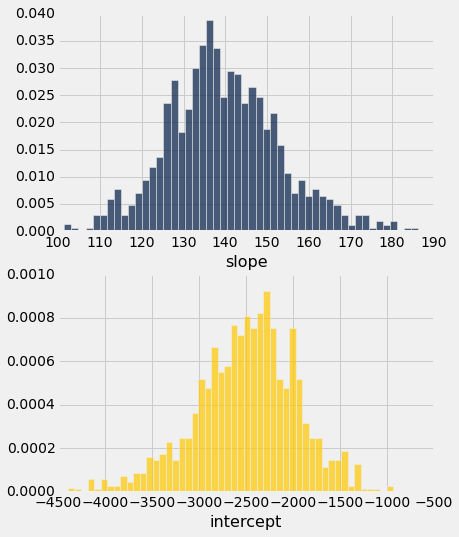

In [27]:
smokesamples = Table.from_rows([rboot(smoke,'Gest','Wgt') for i in range(num_samples)],['slope','intercept'])
smokesamples.hist(bins=50,normed=True)

In [28]:
smokesamples.stats([np.min,np.mean,np.max])

statistic,slope,intercept
amin,101.412,-4394.11
mean,139.554,-2497.68
amax,186.222,-935.15


In [29]:
# So now we have an estimate of the distribution of birthweights at week 40 for something closer to the populations
# that these small samples attempt represent
weights_40 = Table([nosamples['slope']*40+nosamples['intercept'],
                    smokesamples['slope']*40+smokesamples['intercept']],['nosmoke','smoke'])
weights_40

nosmoke,smoke
3393.2,3085.23
3281.4,3110.62
3356.31,3093.87
3340.72,3052.84
3370.59,3032.13
3330.16,3055.24
3281.83,3085.45
3366.31,3125.69
3358.3,3089.82
3296.59,3065.2


In [30]:
weights_40['Smoke Wgt Loss'] = weights_40['nosmoke'] - weights_40['smoke']

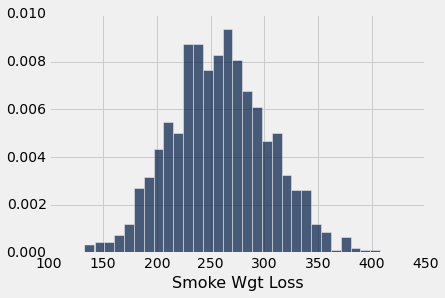

In [31]:
# what do we expect the distribution of birthweight reduction due to smoking to look like
# for the population represented by the original sample?
weights_40.select('Smoke Wgt Loss').hist(bins=30,normed=True)  

In [32]:
smoke_diff

255.55207244862686

In [33]:
def firstQtile(x) : return np.percentile(x,25)
def thirdQtile(x) : return np.percentile(x,25)
summary_ops = (min, firstQtile, np.median, np.mean, thirdQtile, max)

In [34]:
summary = weights_40.stats(summary_ops)
summary

statistic,nosmoke,smoke,Smoke Wgt Loss
min,3251.01,2986.49,132.761
firstQtile,3322.11,3064.2,228.624
median,3341.71,3084.45,258.983
mean,3343.57,3084.5,259.071
thirdQtile,3322.11,3064.2,228.624
max,3491.15,3174.6,407.92


In [35]:
summary['diff']=summary['nosmoke']-summary['smoke']

In [36]:
# the bottom line
summary

statistic,nosmoke,smoke,Smoke Wgt Loss,diff
min,3251.01,2986.49,132.761,264.516
firstQtile,3322.11,3064.2,228.624,257.914
median,3341.71,3084.45,258.983,257.264
mean,3343.57,3084.5,259.071,259.071
thirdQtile,3322.11,3064.2,228.624,257.914
max,3491.15,3174.6,407.92,316.549


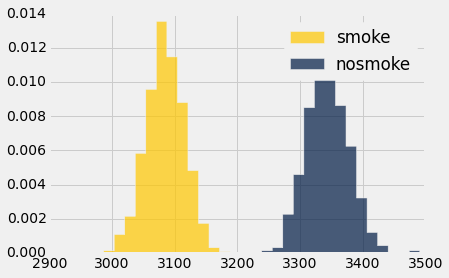

In [37]:
weights_40.select(['smoke','nosmoke']).hist(overlay=True,bins=30,normed=True)  